# Calculate SPEI and drought characteristics from observational data

In [112]:
### SPEI calc and plot
# Calculates the standardized precipitation and evapotranspiration (SPEI) drought index for observations (CHIRPS and CRU) and plots a timeseries 
# Output: plot of average SPEI over Ghana
# Steps:
#      1. Imports CRU and chirps data model data
#      2. Subsets observations to Ghana and regrid
#      3. Calculates monthly average temp and precip for years of interest
#      4. Calculates potential evapotranspiation and SPEI using climate indices packages, saving as a cube
#      5. Gets average SPEI over country
#      6. Turns cube into dataframe (may be useful if plotting multiple models)
#      7. Plots SPEI timeseries
#
## Author: S Chapman
## Date: 20/05/2021

#Import packages
import iris
import iris.plot as iplt
import iris.quickplot as qplt
import iris.coord_categorisation

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import copy

import climate_indices
from climate_indices import compute, indices

### Load Data

In [113]:
## Load data
#precip
file_path ='/gws/pw/j05/cop26_hackathons/leeds/CHIRPS/'
pr = iris.load_cube(file_path + 'chirps.nc')

#load tas
file_path = '/gws/pw/j05/cop26_hackathons/leeds/ministry/obs_datasets/CRU/'
tas = iris.load(file_path + 'cru*.nc', 
               iris.Constraint(cube_func = lambda cube: cube.var_name == 'tmp'))
tas = tas.concatenate_cube()

In [114]:
#convert units
pr.units = 'kg m-2 day-1'
tas.units = 'celsius'


### Extract to area and years of interest

In [115]:
##extract to region of interest and regrid
#define area of interest
def ghana_lat(input):
    return 4.0 <= input <= 11.5

def ghana_lon(input):
    return -3 <= input <= 1.0

#guess bounds for regridding
tas.coord('latitude').guess_bounds()
tas.coord('longitude').guess_bounds()
pr.coord('latitude').guess_bounds()
pr.coord('longitude').guess_bounds()

#extract ghana
ghana_con = iris.Constraint(latitude = ghana_lat, longitude =  ghana_lon)
#ghana_con = iris.Constraint(latitude = ghana_lat)

ghana_pr = pr.extract(ghana_con)
ghana_tas = tas.extract(ghana_con)

#regrid cru to chirps (chirps higher resolution, so would probably usually do it the other way)
ghana_tas_regrid = ghana_tas.regrid(ghana_pr, iris.analysis.AreaWeighted())

### Calculate monthly mean

In [117]:
#add month coord and calculate monthly mean
iris.coord_categorisation.add_month_number(ghana_pr, 'time', name='month')
iris.coord_categorisation.add_month_number(ghana_tas_regrid, 'time', name='month')
iris.coord_categorisation.add_year(ghana_pr, 'time', name='year')
iris.coord_categorisation.add_year(ghana_tas_regrid, 'time', name='year')

#extract years of interest 1980 - 2010
ghana_pr = ghana_pr.extract(iris.Constraint(year = lambda cell: 1980 <= cell <= 2010))
ghana_tas_regrid = ghana_tas_regrid.extract(iris.Constraint(year = lambda cell: 1980 <= cell <= 2010))

pr_mean = ghana_pr.aggregated_by(['month', 'year'], iris.analysis.MEAN)
tas_mean = ghana_tas_regrid.aggregated_by(['month', 'year'], iris.analysis.MEAN)

### Calculate SPEI

In [118]:
#set up variables for calculating SPEI

syear = 1980
calib_year_init = 1980
calib_year_final = 1982
dims = pr_mean.shape

#create cubes for storing data
spei_cube = copy.deepcopy(pr_mean)
pet_cube = copy.deepcopy(tas_mean)

In [119]:
for j in np.arange(dims[1]):
    for k in np.arange(dims[2]):

        x_pr = pr_mean[:, j, k].data
        x_tas = tas_mean[:, j, k].data

        lat = pr_mean[0, j,k].coord('latitude').points[0]
        
        #calculate pet
        pet = indices.pet(x_tas, lat, syear)
        pet_cube.data[:,j,k] = pet
        
        #calcualte spei
        kwargs = dict(
            precips_mm = x_pr,
            pet_mm = pet[0:dims[0]],
            scale = 1, # months over which to calculate SPEI, i.e., 3 month running mean etc
            distribution = indices.Distribution.gamma,
            periodicity = indices.compute.Periodicity.monthly, #time scale of input data (needs to be monthly for SPEI)
            data_start_year = syear,
            calibration_year_initial = calib_year_init,
            calibration_year_final = calib_year_final,
            fitting_params=None
        )
        spei = indices.spei(**kwargs)        
        spei_cube.data[:,j,k] = spei
        
        
        

### Plot SPEI

In [159]:
##plot time series
#calculate mean SPEI over ghana
spei_north = spei_cube.extract(iris.Constraint(latitude = lambda cell: cell >= 7.0))
spei_nmean = spei_north.collapsed(['latitude', 'longitude'], iris.analysis.MEAN)

spei_south = spei_cube.extract(iris.Constraint(latitude = lambda cell: cell < 7.0))
spei_smean = spei_south.collapsed(['latitude', 'longitude'], iris.analysis.MEAN)

spei_mean = spei_cube.collapsed(['latitude', 'longitude'], iris.analysis.MEAN)

In [160]:
#turn into dataframe and extract year

def cube_to_frame(cube_list, mods): # set up in case calculate SPEI for multiple models
    df = pd.DataFrame(columns = ['mod', 'sim', 'year', 'month', 'value'])
    
    for i in np.arange(len(cube_list)):
        cube =  cube_list[i]
        mod = mods[i]
        sim = 'hist' #extract from attributes later
        
        x = cube.data
        x = x[~x.mask].flatten() #if masked to land sea, which isn't as moment
        
        
        year =  cube.coord('year').points
        month = cube.coord('month').points
        
        y = pd.DataFrame(columns =   ['mod', 'sim', 'year', 'month', 'value'])
       
        y['value'] = x
        y['year'] = year
        y['mod'] = mod
        y['sim'] = sim
        y['month'] = month
        
        df= df.append(y)
    
    return df

mod_list = ['north', 'south', 'all']

spei_df = cube_to_frame([spei_nmean, spei_smean, spei_mean], mods = mod_list)

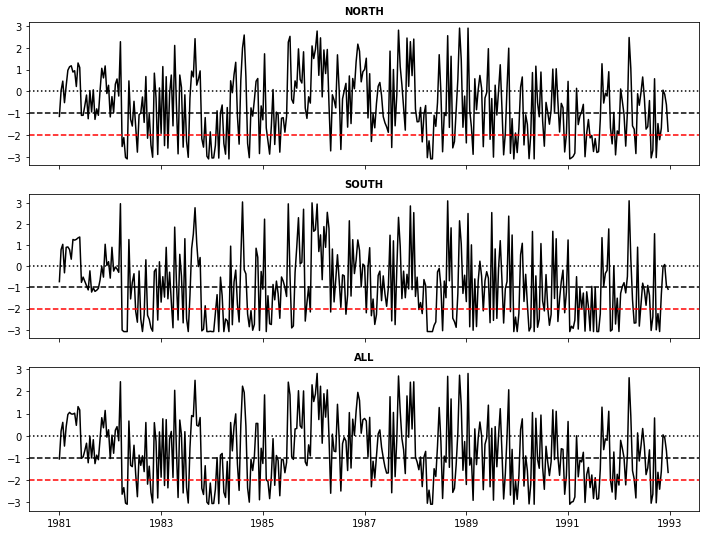

In [175]:
fig = plt.figure(figsize = (12,9))
ax1 =  fig.add_subplot(311)
ax2 =  fig.add_subplot(312)
ax3 =  fig.add_subplot(313)

ax_list = [ax1, ax2, ax3]

for ax in ax_list:
    ax.set_xticks(np.arange(0, 420, 60))
    ax.set_xticklabels(''*7)

years =  np.unique(spei_df['year'])
ax3.set_xticklabels(years[::2])

xpos, ypos = 0.5, 1.05 # positions for figure labels

for i in np.arange(len(ax_list)):
    ax = ax_list[i]
    m = mod_list[i]
    df = spei_df[spei_df['mod'] == m]

    ax.plot(df['value'], c = 'black', label = 'SPEI')

    ax.axhline(y = 0, color = 'black', linestyle = 'dotted')
    ax.axhline(y = -1, color = 'black', linestyle = 'dashed', label = 'Drought threshold')
    ax.axhline(y = -2, color = 'red', linestyle = 'dashed', label = 'Extreme drought threshold')

    ax.annotate(s = m.upper(), xy = (xpos, ypos), xycoords = 'axes fraction',ha = 'center',
             weight = 'bold')
        
ax2.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.20), ncol = 3, frameon = False)

### Extract characteristics of 1983 drought

In [181]:
df_1983 = spei_df[spei_df['year'] <= 1985]
df_1983['drought'] = 0

df_1983['drought'][df_1983['value'] <= -1] = 1

df_north = df_1983[df_1983['mod'] == 'north']
df_south = df_1983[df_1983['mod'] == 'south']
df_all = df_1983[df_1983['mod'] == 'all']

def count_dur(y):
    x = y * (y.groupby((y != y.shift()).cumsum()).cumcount() + 1)
    return x

df_north['duration'] = count_dur(df_north['drought'])
df_south['duration'] = count_dur(df_south['drought'])
df_all['duration'] = count_dur(df_all['drought'])

In [200]:
df_list = [df_north, df_south, df_all]

for df in df_list:
    df['duration'] = count_dur(df['drought'])
    
    reg = np.unique(df['mod'])[0]
    loc_max = df['duration'].argmax()
    year_max = df['year'].loc[loc_max]
    max_drought = np.max(df['duration'])
    
    print(reg.upper(), ':')
    print('Max length of drought', max_drought, 'months in', year_max)
    
    #find max drought intensity during longest drought
    df_small = df.loc[loc_max - max_drought: loc_max]
    print('Max drought intensity: ', np.nanmin(df_small['value']))


NORTH :
Max length of drought 4 months in 1984
Max drought intensity:  -3.0899999999999994
SOUTH :
Max length of drought 5 months in 1982
Max drought intensity:  -1.2226304351423491
ALL :
Max length of drought 4 months in 1984
Max drought intensity:  -3.09
